# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

#helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

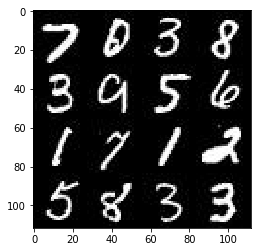

In [2]:
show_n_images = 16

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

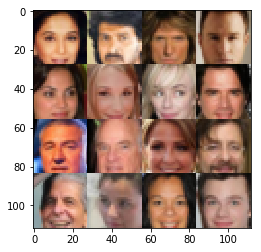

In [3]:
show_n_images = 16

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    image = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    z_input = tf.placeholder(tf.float32, (None, z_dim))
    lr = tf.placeholder(tf.float32, ()) #lr is just a constant
    #print('image_batch size: ',image.get_shape().as_list())
    #print('z_input size: ',z_input.get_shape().as_list())
    #print('lr size: ',lr.get_shape().as_list())
    
    return image, z_input, lr

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # create 3 conv layers & 1 fc layer
    # alpha is the value for lrelu, set to a constant
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
            #first input layer is 28x28x1 (mnist) or 28*28*3 (celebA)
            ###print('image input shape: ', images.get_shape().as_list())
            conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
            ###print('conv1 layer output shape: ', conv1.get_shape().as_list())
            #no batch norm for 1st conv layer
            relu1 = tf.maximum(alpha*conv1, conv1)
            # relu1 is 14x14x64
            
            conv2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
            ###print('conv2 layer output shape: ', conv2.get_shape().as_list())
            bn2 = tf.layers.batch_normalization(conv2, training=True)
            relu2 = tf.maximum(alpha*bn2, bn2)
            # relu1 is 7x7x128
            
            conv3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
            ###print('conv3 layer output shape: ', conv3.get_shape().as_list())
            bn3 = tf.layers.batch_normalization(conv3, training=True)
            relu3 = tf.maximum(alpha*bn2, bn2)
            # relu1 is 4x4x256
            
            #flatten the layer
            flat = tf.reshape(relu3, (-1,4*4*256))
            logits = tf.layers.dense(flat,1)
            out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # create 1 fc layer, 3 conv layers & 1 output layer
    # alpha is the value for lrelu, set to a constant
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        
        #create first fc layer
        fc1 = tf.layers.dense(z, 4*4*512)
        ###print('fc1 layer output shape: ', fc1.get_shape().as_list())
        #fc1 is 28*28*out_channel_dim (for the test case it's 28*28*5 = 3920)
        
        #reshape fc1 to start the generator 
        conv1 = tf.reshape(fc1, (-1,4,4,512))
        ###print('conv1 layer output shape: ', conv1.get_shape().as_list())
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        relu1 = tf.maximum(alpha*conv1, conv1)
        #relu1 is 4x4x512
        
        #conv layer 2
        conv2 = tf.layers.conv2d_transpose(relu1, 256, 4, strides=1, padding='valid')
        ###print('conv2 layer output shape: ', conv2.get_shape().as_list())
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        relu2 = tf.maximum(alpha*conv2, conv2)
        #relu2 is 7x7x256
        
        #conv layer3
        conv3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding='same')
        ###print('conv3 layer output shape: ', conv3.get_shape().as_list())
        conv3 = tf.layers.batch_normalization(conv3, training=is_train)
        relu3 = tf.maximum(alpha*conv3, conv3)
        #relu3 is 14x14x128
        
        #output layer
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=2, padding='same')
        ###print('output layer shape: ', logits.get_shape().as_list())
        #logits is 28x28xout_channel_dim
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    #get weights and bias that needs updating
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimization
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    print_every = 20
    show_every = 200
    
    #create placeholders
    image_batch, z_input, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    #print('image_batch size: ',image_batch.get_shape().as_list())
    #print('z_input size: ',z_input.get_shape().as_list())
    #print('lr size: ',lr.get_shape().as_list())
    
    #create d & g loss functions
    d_loss, g_loss = model_loss(image_batch, z_input, data_shape[3])
    #print('d_loss size: ',d_loss.get_shape().as_list())
    #print('g_loss size: ',g_loss.get_shape().as_list())
    
    #create function to optimize d & g training
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
       
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            
            #to keep track of every batch in every epoch
            batch_num = 0 
            
            for batch_images in get_batches(batch_size):
                
                batch_num+=1
                
                #to rescale to -1 to 1 because of tanh
                batch_images = batch_images*2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                #print('batch_z size: ',batch_z.shape )
                #print('batch_images size: ',batch_images.shape )
                
                # Run optimizers
                # Optimize Discriminator
                #print('batch_images size: ',batch_images.get_shape().as_list())
                _ = sess.run(d_train_opt, feed_dict={image_batch: batch_images, z_input: batch_z, lr: learning_rate}) #problem
                # Optimize Generator once
                _ = sess.run(g_train_opt, feed_dict={image_batch: batch_images, z_input: batch_z, lr: learning_rate})
               
                #find losses and print values every print_every
                if batch_num % print_every == 0:
                    
                    train_loss_d = d_loss.eval({image_batch: batch_images, z_input: batch_z})
                    train_loss_g = g_loss.eval({image_batch: batch_images, z_input: batch_z})
                    
                    #print the stats and losses
                    print("Epoch {}/{}, ".format(epoch_i+1, epochs),
                          "Batch {}, ".format(batch_num),
                          "Discriminator Loss: {:.4f}, ".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if batch_num % show_every == 0:
                    show_generator_output(sess, 16, z_input, data_shape[3], data_image_mode)
                    
                    
        show_generator_output(sess, 16, z_input, data_shape[3], data_image_mode)           
        print('GAN is completed.')
                    
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2,  Batch 20,  Discriminator Loss: 1.8388,  Generator Loss: 0.3523
Epoch 1/2,  Batch 40,  Discriminator Loss: 1.5339,  Generator Loss: 0.5270
Epoch 1/2,  Batch 60,  Discriminator Loss: 1.5656,  Generator Loss: 0.4924
Epoch 1/2,  Batch 80,  Discriminator Loss: 1.4097,  Generator Loss: 0.6656
Epoch 1/2,  Batch 100,  Discriminator Loss: 1.3307,  Generator Loss: 0.7014
Epoch 1/2,  Batch 120,  Discriminator Loss: 1.2757,  Generator Loss: 0.7444
Epoch 1/2,  Batch 140,  Discriminator Loss: 1.3564,  Generator Loss: 0.7077
Epoch 1/2,  Batch 160,  Discriminator Loss: 1.3925,  Generator Loss: 0.6973
Epoch 1/2,  Batch 180,  Discriminator Loss: 1.3371,  Generator Loss: 0.7207
Epoch 1/2,  Batch 200,  Discriminator Loss: 1.3054,  Generator Loss: 0.7545


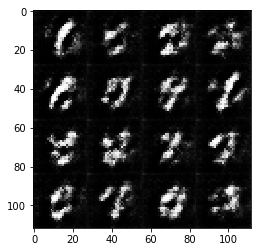

Epoch 1/2,  Batch 220,  Discriminator Loss: 1.2676,  Generator Loss: 0.8115
Epoch 1/2,  Batch 240,  Discriminator Loss: 1.3341,  Generator Loss: 0.7282
Epoch 1/2,  Batch 260,  Discriminator Loss: 1.2409,  Generator Loss: 0.8210
Epoch 1/2,  Batch 280,  Discriminator Loss: 1.4198,  Generator Loss: 0.7088
Epoch 1/2,  Batch 300,  Discriminator Loss: 1.2595,  Generator Loss: 0.8489
Epoch 1/2,  Batch 320,  Discriminator Loss: 1.2558,  Generator Loss: 0.8234
Epoch 1/2,  Batch 340,  Discriminator Loss: 1.3200,  Generator Loss: 0.7767
Epoch 1/2,  Batch 360,  Discriminator Loss: 1.3108,  Generator Loss: 0.8217
Epoch 1/2,  Batch 380,  Discriminator Loss: 1.2773,  Generator Loss: 0.8286
Epoch 1/2,  Batch 400,  Discriminator Loss: 1.3012,  Generator Loss: 0.8401


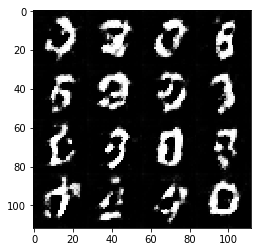

Epoch 1/2,  Batch 420,  Discriminator Loss: 1.1758,  Generator Loss: 0.8990
Epoch 1/2,  Batch 440,  Discriminator Loss: 1.1986,  Generator Loss: 0.8389
Epoch 1/2,  Batch 460,  Discriminator Loss: 1.2851,  Generator Loss: 0.8218
Epoch 1/2,  Batch 480,  Discriminator Loss: 1.2579,  Generator Loss: 0.8625
Epoch 1/2,  Batch 500,  Discriminator Loss: 1.2985,  Generator Loss: 0.8086
Epoch 1/2,  Batch 520,  Discriminator Loss: 1.2784,  Generator Loss: 0.8132
Epoch 1/2,  Batch 540,  Discriminator Loss: 1.2775,  Generator Loss: 0.8328
Epoch 1/2,  Batch 560,  Discriminator Loss: 1.2398,  Generator Loss: 0.8760
Epoch 1/2,  Batch 580,  Discriminator Loss: 1.2521,  Generator Loss: 0.8116
Epoch 1/2,  Batch 600,  Discriminator Loss: 1.2681,  Generator Loss: 0.8374


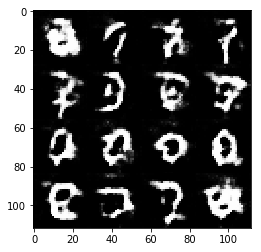

Epoch 1/2,  Batch 620,  Discriminator Loss: 1.2849,  Generator Loss: 0.8504
Epoch 1/2,  Batch 640,  Discriminator Loss: 1.2597,  Generator Loss: 0.8534
Epoch 1/2,  Batch 660,  Discriminator Loss: 1.2475,  Generator Loss: 0.8807
Epoch 1/2,  Batch 680,  Discriminator Loss: 1.2782,  Generator Loss: 0.8101
Epoch 1/2,  Batch 700,  Discriminator Loss: 1.1792,  Generator Loss: 0.9447
Epoch 1/2,  Batch 720,  Discriminator Loss: 1.2538,  Generator Loss: 0.8795
Epoch 1/2,  Batch 740,  Discriminator Loss: 1.2097,  Generator Loss: 0.8431
Epoch 1/2,  Batch 760,  Discriminator Loss: 1.1568,  Generator Loss: 0.8963
Epoch 1/2,  Batch 780,  Discriminator Loss: 1.2195,  Generator Loss: 0.8839
Epoch 1/2,  Batch 800,  Discriminator Loss: 1.3109,  Generator Loss: 0.8354


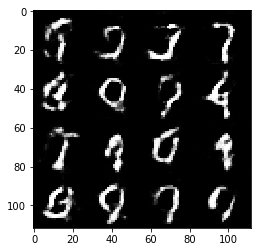

Epoch 1/2,  Batch 820,  Discriminator Loss: 1.2358,  Generator Loss: 0.8765
Epoch 1/2,  Batch 840,  Discriminator Loss: 1.2032,  Generator Loss: 0.8734
Epoch 1/2,  Batch 860,  Discriminator Loss: 1.2157,  Generator Loss: 0.8823
Epoch 1/2,  Batch 880,  Discriminator Loss: 1.3015,  Generator Loss: 0.8736
Epoch 1/2,  Batch 900,  Discriminator Loss: 1.2307,  Generator Loss: 0.8566
Epoch 1/2,  Batch 920,  Discriminator Loss: 1.2505,  Generator Loss: 0.8869
Epoch 1/2,  Batch 940,  Discriminator Loss: 1.2808,  Generator Loss: 0.7977
Epoch 1/2,  Batch 960,  Discriminator Loss: 1.2841,  Generator Loss: 0.8511
Epoch 1/2,  Batch 980,  Discriminator Loss: 1.2685,  Generator Loss: 0.8082
Epoch 1/2,  Batch 1000,  Discriminator Loss: 1.2891,  Generator Loss: 0.8178


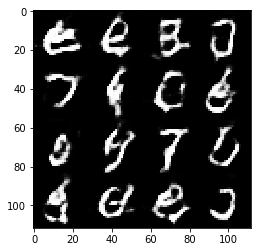

Epoch 1/2,  Batch 1020,  Discriminator Loss: 1.2908,  Generator Loss: 0.8316
Epoch 1/2,  Batch 1040,  Discriminator Loss: 1.3228,  Generator Loss: 0.7925
Epoch 1/2,  Batch 1060,  Discriminator Loss: 1.2645,  Generator Loss: 0.8125
Epoch 1/2,  Batch 1080,  Discriminator Loss: 1.2230,  Generator Loss: 0.8941
Epoch 1/2,  Batch 1100,  Discriminator Loss: 1.2595,  Generator Loss: 0.8555
Epoch 1/2,  Batch 1120,  Discriminator Loss: 1.2729,  Generator Loss: 0.9067
Epoch 1/2,  Batch 1140,  Discriminator Loss: 1.3058,  Generator Loss: 0.8255
Epoch 1/2,  Batch 1160,  Discriminator Loss: 1.2579,  Generator Loss: 0.8512
Epoch 1/2,  Batch 1180,  Discriminator Loss: 1.2508,  Generator Loss: 0.8280
Epoch 1/2,  Batch 1200,  Discriminator Loss: 1.2162,  Generator Loss: 0.8745


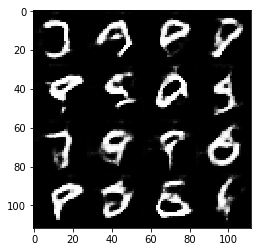

Epoch 1/2,  Batch 1220,  Discriminator Loss: 1.2928,  Generator Loss: 0.8514
Epoch 1/2,  Batch 1240,  Discriminator Loss: 1.2887,  Generator Loss: 0.8636
Epoch 1/2,  Batch 1260,  Discriminator Loss: 1.1752,  Generator Loss: 0.9057
Epoch 1/2,  Batch 1280,  Discriminator Loss: 1.2723,  Generator Loss: 0.8715
Epoch 1/2,  Batch 1300,  Discriminator Loss: 1.2417,  Generator Loss: 0.8936
Epoch 1/2,  Batch 1320,  Discriminator Loss: 1.2704,  Generator Loss: 0.8298
Epoch 1/2,  Batch 1340,  Discriminator Loss: 1.2332,  Generator Loss: 0.8622
Epoch 1/2,  Batch 1360,  Discriminator Loss: 1.3691,  Generator Loss: 0.7613
Epoch 1/2,  Batch 1380,  Discriminator Loss: 1.2833,  Generator Loss: 0.8152
Epoch 1/2,  Batch 1400,  Discriminator Loss: 1.3118,  Generator Loss: 0.8680


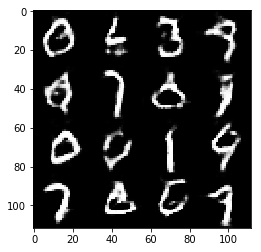

Epoch 1/2,  Batch 1420,  Discriminator Loss: 1.2669,  Generator Loss: 0.8102
Epoch 1/2,  Batch 1440,  Discriminator Loss: 1.2400,  Generator Loss: 0.8817
Epoch 1/2,  Batch 1460,  Discriminator Loss: 1.2574,  Generator Loss: 0.8544
Epoch 1/2,  Batch 1480,  Discriminator Loss: 1.2416,  Generator Loss: 0.8346
Epoch 1/2,  Batch 1500,  Discriminator Loss: 1.2381,  Generator Loss: 0.8389
Epoch 1/2,  Batch 1520,  Discriminator Loss: 1.1849,  Generator Loss: 0.9019
Epoch 1/2,  Batch 1540,  Discriminator Loss: 1.2338,  Generator Loss: 0.8497
Epoch 1/2,  Batch 1560,  Discriminator Loss: 1.2180,  Generator Loss: 0.8693
Epoch 1/2,  Batch 1580,  Discriminator Loss: 1.2466,  Generator Loss: 0.8884
Epoch 1/2,  Batch 1600,  Discriminator Loss: 1.2753,  Generator Loss: 0.7913


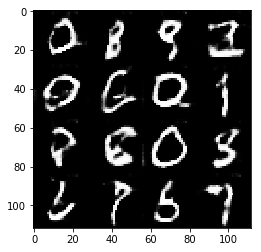

Epoch 1/2,  Batch 1620,  Discriminator Loss: 1.2315,  Generator Loss: 0.8967
Epoch 1/2,  Batch 1640,  Discriminator Loss: 1.2544,  Generator Loss: 0.8616
Epoch 1/2,  Batch 1660,  Discriminator Loss: 1.2271,  Generator Loss: 0.9422
Epoch 1/2,  Batch 1680,  Discriminator Loss: 1.1671,  Generator Loss: 0.9744
Epoch 1/2,  Batch 1700,  Discriminator Loss: 1.2459,  Generator Loss: 0.9074
Epoch 1/2,  Batch 1720,  Discriminator Loss: 1.3929,  Generator Loss: 0.7563
Epoch 1/2,  Batch 1740,  Discriminator Loss: 1.2518,  Generator Loss: 0.8025
Epoch 1/2,  Batch 1760,  Discriminator Loss: 1.2223,  Generator Loss: 0.7959
Epoch 1/2,  Batch 1780,  Discriminator Loss: 1.2115,  Generator Loss: 0.9896
Epoch 1/2,  Batch 1800,  Discriminator Loss: 1.1927,  Generator Loss: 0.8583


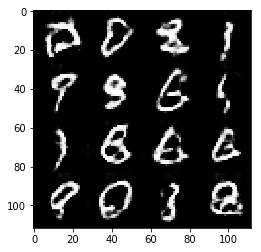

Epoch 1/2,  Batch 1820,  Discriminator Loss: 1.2090,  Generator Loss: 0.8372
Epoch 1/2,  Batch 1840,  Discriminator Loss: 1.2542,  Generator Loss: 0.8595
Epoch 1/2,  Batch 1860,  Discriminator Loss: 1.1960,  Generator Loss: 0.9191
Epoch 2/2,  Batch 20,  Discriminator Loss: 1.1844,  Generator Loss: 0.8426
Epoch 2/2,  Batch 40,  Discriminator Loss: 1.1678,  Generator Loss: 0.8963
Epoch 2/2,  Batch 60,  Discriminator Loss: 1.2187,  Generator Loss: 0.9923
Epoch 2/2,  Batch 80,  Discriminator Loss: 1.1657,  Generator Loss: 0.8883
Epoch 2/2,  Batch 100,  Discriminator Loss: 1.1812,  Generator Loss: 0.8955
Epoch 2/2,  Batch 120,  Discriminator Loss: 1.2340,  Generator Loss: 0.8711
Epoch 2/2,  Batch 140,  Discriminator Loss: 1.2280,  Generator Loss: 0.9105
Epoch 2/2,  Batch 160,  Discriminator Loss: 1.1857,  Generator Loss: 0.8739
Epoch 2/2,  Batch 180,  Discriminator Loss: 1.1797,  Generator Loss: 0.8313
Epoch 2/2,  Batch 200,  Discriminator Loss: 1.1991,  Generator Loss: 0.8401


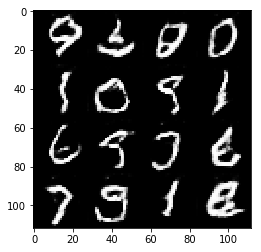

Epoch 2/2,  Batch 220,  Discriminator Loss: 1.1956,  Generator Loss: 0.9281
Epoch 2/2,  Batch 240,  Discriminator Loss: 1.2022,  Generator Loss: 0.9481
Epoch 2/2,  Batch 260,  Discriminator Loss: 1.1575,  Generator Loss: 0.9262
Epoch 2/2,  Batch 280,  Discriminator Loss: 1.1671,  Generator Loss: 0.8856
Epoch 2/2,  Batch 300,  Discriminator Loss: 1.2407,  Generator Loss: 0.7896
Epoch 2/2,  Batch 320,  Discriminator Loss: 1.2616,  Generator Loss: 0.8533
Epoch 2/2,  Batch 340,  Discriminator Loss: 1.2015,  Generator Loss: 0.9005
Epoch 2/2,  Batch 360,  Discriminator Loss: 1.1882,  Generator Loss: 0.9260
Epoch 2/2,  Batch 380,  Discriminator Loss: 1.1431,  Generator Loss: 0.9618
Epoch 2/2,  Batch 400,  Discriminator Loss: 1.1475,  Generator Loss: 0.9261


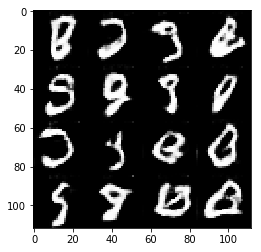

Epoch 2/2,  Batch 420,  Discriminator Loss: 1.1648,  Generator Loss: 0.8568
Epoch 2/2,  Batch 440,  Discriminator Loss: 1.1711,  Generator Loss: 0.8661
Epoch 2/2,  Batch 460,  Discriminator Loss: 1.2352,  Generator Loss: 0.8848
Epoch 2/2,  Batch 480,  Discriminator Loss: 1.1941,  Generator Loss: 1.0207
Epoch 2/2,  Batch 500,  Discriminator Loss: 1.1441,  Generator Loss: 0.8850
Epoch 2/2,  Batch 520,  Discriminator Loss: 1.1187,  Generator Loss: 0.8184
Epoch 2/2,  Batch 540,  Discriminator Loss: 1.1870,  Generator Loss: 1.0033
Epoch 2/2,  Batch 560,  Discriminator Loss: 1.1888,  Generator Loss: 0.8440
Epoch 2/2,  Batch 580,  Discriminator Loss: 1.1533,  Generator Loss: 0.9792
Epoch 2/2,  Batch 600,  Discriminator Loss: 1.2036,  Generator Loss: 0.9268


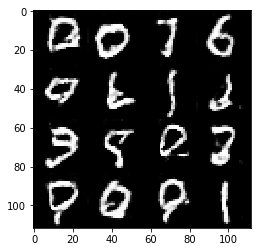

Epoch 2/2,  Batch 620,  Discriminator Loss: 1.2170,  Generator Loss: 1.0572
Epoch 2/2,  Batch 640,  Discriminator Loss: 1.1551,  Generator Loss: 0.9727
Epoch 2/2,  Batch 660,  Discriminator Loss: 1.2177,  Generator Loss: 0.8786
Epoch 2/2,  Batch 680,  Discriminator Loss: 1.1349,  Generator Loss: 1.0590
Epoch 2/2,  Batch 700,  Discriminator Loss: 1.1151,  Generator Loss: 0.9648
Epoch 2/2,  Batch 720,  Discriminator Loss: 1.1544,  Generator Loss: 0.9179
Epoch 2/2,  Batch 740,  Discriminator Loss: 1.1346,  Generator Loss: 0.9429
Epoch 2/2,  Batch 760,  Discriminator Loss: 1.1283,  Generator Loss: 0.9542
Epoch 2/2,  Batch 780,  Discriminator Loss: 1.1147,  Generator Loss: 1.0103
Epoch 2/2,  Batch 800,  Discriminator Loss: 1.1605,  Generator Loss: 1.0155


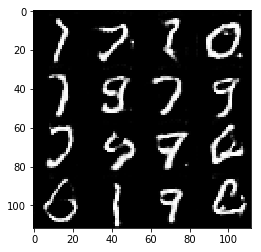

Epoch 2/2,  Batch 820,  Discriminator Loss: 1.0834,  Generator Loss: 1.0619
Epoch 2/2,  Batch 840,  Discriminator Loss: 1.1019,  Generator Loss: 0.9386
Epoch 2/2,  Batch 860,  Discriminator Loss: 1.1800,  Generator Loss: 0.8032
Epoch 2/2,  Batch 880,  Discriminator Loss: 1.2468,  Generator Loss: 0.7293
Epoch 2/2,  Batch 900,  Discriminator Loss: 1.0916,  Generator Loss: 0.9638
Epoch 2/2,  Batch 920,  Discriminator Loss: 1.1279,  Generator Loss: 1.1545
Epoch 2/2,  Batch 940,  Discriminator Loss: 1.1943,  Generator Loss: 0.8080
Epoch 2/2,  Batch 960,  Discriminator Loss: 1.1001,  Generator Loss: 0.9597
Epoch 2/2,  Batch 980,  Discriminator Loss: 1.0854,  Generator Loss: 0.9718
Epoch 2/2,  Batch 1000,  Discriminator Loss: 1.1199,  Generator Loss: 0.8780


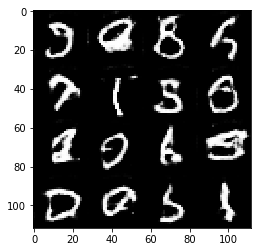

Epoch 2/2,  Batch 1020,  Discriminator Loss: 1.3061,  Generator Loss: 0.8085
Epoch 2/2,  Batch 1040,  Discriminator Loss: 1.1360,  Generator Loss: 0.9653
Epoch 2/2,  Batch 1060,  Discriminator Loss: 1.1128,  Generator Loss: 1.1600
Epoch 2/2,  Batch 1080,  Discriminator Loss: 1.1267,  Generator Loss: 0.8284
Epoch 2/2,  Batch 1100,  Discriminator Loss: 1.0083,  Generator Loss: 1.0123
Epoch 2/2,  Batch 1120,  Discriminator Loss: 1.2779,  Generator Loss: 0.6817
Epoch 2/2,  Batch 1140,  Discriminator Loss: 1.1764,  Generator Loss: 0.9214
Epoch 2/2,  Batch 1160,  Discriminator Loss: 1.1362,  Generator Loss: 1.1097
Epoch 2/2,  Batch 1180,  Discriminator Loss: 1.1093,  Generator Loss: 0.9351
Epoch 2/2,  Batch 1200,  Discriminator Loss: 1.1785,  Generator Loss: 0.9129


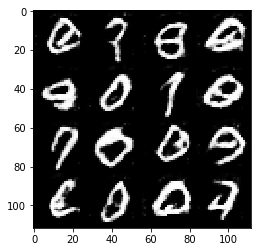

Epoch 2/2,  Batch 1220,  Discriminator Loss: 1.2195,  Generator Loss: 1.0317
Epoch 2/2,  Batch 1240,  Discriminator Loss: 1.0860,  Generator Loss: 0.9363
Epoch 2/2,  Batch 1260,  Discriminator Loss: 1.0400,  Generator Loss: 1.1200
Epoch 2/2,  Batch 1280,  Discriminator Loss: 1.1134,  Generator Loss: 1.1451
Epoch 2/2,  Batch 1300,  Discriminator Loss: 1.1063,  Generator Loss: 1.1385
Epoch 2/2,  Batch 1320,  Discriminator Loss: 1.1327,  Generator Loss: 0.9335
Epoch 2/2,  Batch 1340,  Discriminator Loss: 1.1226,  Generator Loss: 1.1405
Epoch 2/2,  Batch 1360,  Discriminator Loss: 1.2105,  Generator Loss: 0.9734
Epoch 2/2,  Batch 1380,  Discriminator Loss: 1.1597,  Generator Loss: 0.8641
Epoch 2/2,  Batch 1400,  Discriminator Loss: 1.1813,  Generator Loss: 0.9627


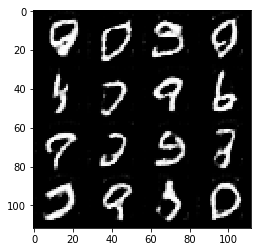

Epoch 2/2,  Batch 1420,  Discriminator Loss: 1.1190,  Generator Loss: 1.0033
Epoch 2/2,  Batch 1440,  Discriminator Loss: 1.1794,  Generator Loss: 0.8940
Epoch 2/2,  Batch 1460,  Discriminator Loss: 1.1049,  Generator Loss: 0.9268
Epoch 2/2,  Batch 1480,  Discriminator Loss: 1.1061,  Generator Loss: 1.0712
Epoch 2/2,  Batch 1500,  Discriminator Loss: 1.0796,  Generator Loss: 0.9186
Epoch 2/2,  Batch 1520,  Discriminator Loss: 1.0686,  Generator Loss: 1.1100
Epoch 2/2,  Batch 1540,  Discriminator Loss: 1.0641,  Generator Loss: 1.1579
Epoch 2/2,  Batch 1560,  Discriminator Loss: 1.1691,  Generator Loss: 0.8901
Epoch 2/2,  Batch 1580,  Discriminator Loss: 1.1489,  Generator Loss: 1.1101
Epoch 2/2,  Batch 1600,  Discriminator Loss: 1.1472,  Generator Loss: 0.9235


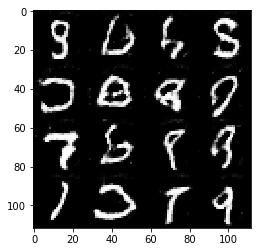

Epoch 2/2,  Batch 1620,  Discriminator Loss: 1.1197,  Generator Loss: 1.0051
Epoch 2/2,  Batch 1640,  Discriminator Loss: 1.1580,  Generator Loss: 0.8417
Epoch 2/2,  Batch 1660,  Discriminator Loss: 1.0401,  Generator Loss: 1.0896
Epoch 2/2,  Batch 1680,  Discriminator Loss: 1.2797,  Generator Loss: 0.7746
Epoch 2/2,  Batch 1700,  Discriminator Loss: 1.0805,  Generator Loss: 0.9605
Epoch 2/2,  Batch 1720,  Discriminator Loss: 1.3122,  Generator Loss: 0.9611
Epoch 2/2,  Batch 1740,  Discriminator Loss: 1.2843,  Generator Loss: 0.9742
Epoch 2/2,  Batch 1760,  Discriminator Loss: 1.0628,  Generator Loss: 1.1411
Epoch 2/2,  Batch 1780,  Discriminator Loss: 1.0156,  Generator Loss: 1.0419
Epoch 2/2,  Batch 1800,  Discriminator Loss: 1.0726,  Generator Loss: 1.0001


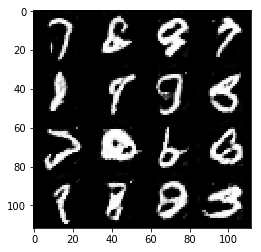

Epoch 2/2,  Batch 1820,  Discriminator Loss: 1.1084,  Generator Loss: 1.0327
Epoch 2/2,  Batch 1840,  Discriminator Loss: 1.1114,  Generator Loss: 0.9782
Epoch 2/2,  Batch 1860,  Discriminator Loss: 1.1851,  Generator Loss: 0.9908


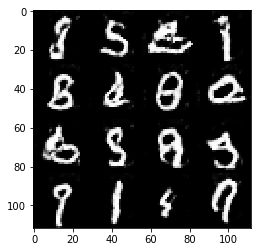

GAN is completed.


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1,  Batch 20,  Discriminator Loss: 2.3384,  Generator Loss: 0.2409
Epoch 1/1,  Batch 40,  Discriminator Loss: 1.6472,  Generator Loss: 0.4529
Epoch 1/1,  Batch 60,  Discriminator Loss: 1.4612,  Generator Loss: 0.5796
Epoch 1/1,  Batch 80,  Discriminator Loss: 1.3953,  Generator Loss: 0.6766
Epoch 1/1,  Batch 100,  Discriminator Loss: 1.2438,  Generator Loss: 0.8008
Epoch 1/1,  Batch 120,  Discriminator Loss: 1.1634,  Generator Loss: 0.9117
Epoch 1/1,  Batch 140,  Discriminator Loss: 1.0056,  Generator Loss: 1.0882
Epoch 1/1,  Batch 160,  Discriminator Loss: 0.7774,  Generator Loss: 1.5273
Epoch 1/1,  Batch 180,  Discriminator Loss: 0.8315,  Generator Loss: 1.2798
Epoch 1/1,  Batch 200,  Discriminator Loss: 0.7236,  Generator Loss: 1.4100


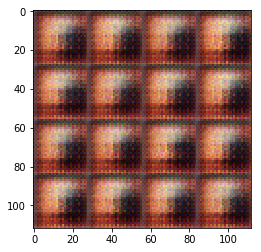

Epoch 1/1,  Batch 220,  Discriminator Loss: 0.5545,  Generator Loss: 2.1871
Epoch 1/1,  Batch 240,  Discriminator Loss: 0.5738,  Generator Loss: 2.0780
Epoch 1/1,  Batch 260,  Discriminator Loss: 0.5997,  Generator Loss: 1.6657
Epoch 1/1,  Batch 280,  Discriminator Loss: 0.5582,  Generator Loss: 2.5017
Epoch 1/1,  Batch 300,  Discriminator Loss: 0.5750,  Generator Loss: 2.3359
Epoch 1/1,  Batch 320,  Discriminator Loss: 0.5902,  Generator Loss: 1.9157
Epoch 1/1,  Batch 340,  Discriminator Loss: 0.4830,  Generator Loss: 2.5244
Epoch 1/1,  Batch 360,  Discriminator Loss: 0.5475,  Generator Loss: 2.0372
Epoch 1/1,  Batch 380,  Discriminator Loss: 0.7007,  Generator Loss: 1.3519
Epoch 1/1,  Batch 400,  Discriminator Loss: 0.4647,  Generator Loss: 2.7077


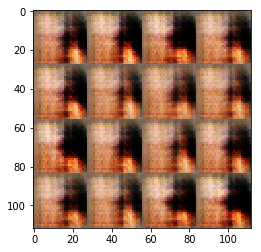

Epoch 1/1,  Batch 420,  Discriminator Loss: 0.6187,  Generator Loss: 1.5578
Epoch 1/1,  Batch 440,  Discriminator Loss: 0.4781,  Generator Loss: 2.6495
Epoch 1/1,  Batch 460,  Discriminator Loss: 0.6002,  Generator Loss: 1.6857
Epoch 1/1,  Batch 480,  Discriminator Loss: 0.5335,  Generator Loss: 2.0572
Epoch 1/1,  Batch 500,  Discriminator Loss: 0.5024,  Generator Loss: 2.6064
Epoch 1/1,  Batch 520,  Discriminator Loss: 0.5994,  Generator Loss: 2.1242
Epoch 1/1,  Batch 540,  Discriminator Loss: 0.5190,  Generator Loss: 2.5432
Epoch 1/1,  Batch 560,  Discriminator Loss: 0.5119,  Generator Loss: 2.3299
Epoch 1/1,  Batch 580,  Discriminator Loss: 0.5435,  Generator Loss: 2.4382
Epoch 1/1,  Batch 600,  Discriminator Loss: 0.6905,  Generator Loss: 2.0309


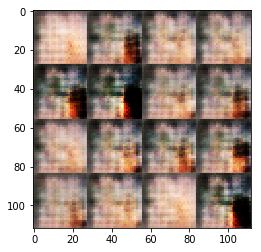

Epoch 1/1,  Batch 620,  Discriminator Loss: 0.7290,  Generator Loss: 1.6967
Epoch 1/1,  Batch 640,  Discriminator Loss: 0.5282,  Generator Loss: 2.0957
Epoch 1/1,  Batch 660,  Discriminator Loss: 0.5716,  Generator Loss: 2.0057
Epoch 1/1,  Batch 680,  Discriminator Loss: 0.6728,  Generator Loss: 1.7521
Epoch 1/1,  Batch 700,  Discriminator Loss: 0.5771,  Generator Loss: 1.9350
Epoch 1/1,  Batch 720,  Discriminator Loss: 0.6576,  Generator Loss: 1.5281
Epoch 1/1,  Batch 740,  Discriminator Loss: 0.6983,  Generator Loss: 2.1447
Epoch 1/1,  Batch 760,  Discriminator Loss: 0.6046,  Generator Loss: 1.7684
Epoch 1/1,  Batch 780,  Discriminator Loss: 0.7544,  Generator Loss: 1.3466
Epoch 1/1,  Batch 800,  Discriminator Loss: 0.5494,  Generator Loss: 2.5028


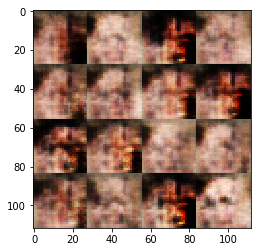

Epoch 1/1,  Batch 820,  Discriminator Loss: 0.7143,  Generator Loss: 1.5151
Epoch 1/1,  Batch 840,  Discriminator Loss: 0.6356,  Generator Loss: 1.6413
Epoch 1/1,  Batch 860,  Discriminator Loss: 0.7480,  Generator Loss: 1.3843
Epoch 1/1,  Batch 880,  Discriminator Loss: 0.7103,  Generator Loss: 1.4784
Epoch 1/1,  Batch 900,  Discriminator Loss: 0.6255,  Generator Loss: 2.0090
Epoch 1/1,  Batch 920,  Discriminator Loss: 0.6386,  Generator Loss: 1.7786
Epoch 1/1,  Batch 940,  Discriminator Loss: 0.7752,  Generator Loss: 1.8506
Epoch 1/1,  Batch 960,  Discriminator Loss: 0.6401,  Generator Loss: 1.8946
Epoch 1/1,  Batch 980,  Discriminator Loss: 0.6509,  Generator Loss: 1.7277
Epoch 1/1,  Batch 1000,  Discriminator Loss: 0.8460,  Generator Loss: 1.3213


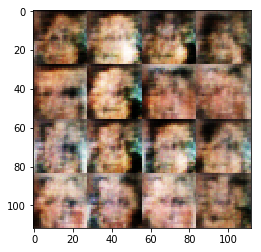

Epoch 1/1,  Batch 1020,  Discriminator Loss: 0.8674,  Generator Loss: 1.5042
Epoch 1/1,  Batch 1040,  Discriminator Loss: 0.8231,  Generator Loss: 1.2782
Epoch 1/1,  Batch 1060,  Discriminator Loss: 0.9223,  Generator Loss: 1.5314
Epoch 1/1,  Batch 1080,  Discriminator Loss: 0.9267,  Generator Loss: 1.1912
Epoch 1/1,  Batch 1100,  Discriminator Loss: 0.7884,  Generator Loss: 1.7194
Epoch 1/1,  Batch 1120,  Discriminator Loss: 0.8833,  Generator Loss: 1.2833
Epoch 1/1,  Batch 1140,  Discriminator Loss: 0.8864,  Generator Loss: 1.3080
Epoch 1/1,  Batch 1160,  Discriminator Loss: 0.7105,  Generator Loss: 1.7407
Epoch 1/1,  Batch 1180,  Discriminator Loss: 0.8791,  Generator Loss: 1.4688
Epoch 1/1,  Batch 1200,  Discriminator Loss: 0.7979,  Generator Loss: 1.4639


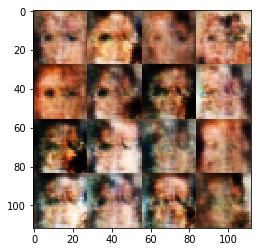

Epoch 1/1,  Batch 1220,  Discriminator Loss: 0.9278,  Generator Loss: 1.0942
Epoch 1/1,  Batch 1240,  Discriminator Loss: 0.7495,  Generator Loss: 1.6641
Epoch 1/1,  Batch 1260,  Discriminator Loss: 0.8889,  Generator Loss: 1.1817
Epoch 1/1,  Batch 1280,  Discriminator Loss: 0.9699,  Generator Loss: 1.1635
Epoch 1/1,  Batch 1300,  Discriminator Loss: 0.8543,  Generator Loss: 1.2343
Epoch 1/1,  Batch 1320,  Discriminator Loss: 0.9221,  Generator Loss: 1.2422
Epoch 1/1,  Batch 1340,  Discriminator Loss: 1.0696,  Generator Loss: 1.0530
Epoch 1/1,  Batch 1360,  Discriminator Loss: 1.1176,  Generator Loss: 1.2278
Epoch 1/1,  Batch 1380,  Discriminator Loss: 0.9711,  Generator Loss: 1.0794
Epoch 1/1,  Batch 1400,  Discriminator Loss: 0.9822,  Generator Loss: 1.3874


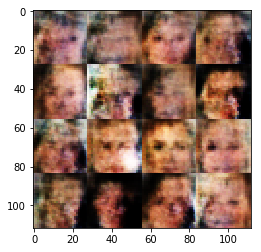

Epoch 1/1,  Batch 1420,  Discriminator Loss: 1.0974,  Generator Loss: 1.0015
Epoch 1/1,  Batch 1440,  Discriminator Loss: 1.0372,  Generator Loss: 1.2184
Epoch 1/1,  Batch 1460,  Discriminator Loss: 0.9492,  Generator Loss: 1.1392
Epoch 1/1,  Batch 1480,  Discriminator Loss: 1.0313,  Generator Loss: 0.9917
Epoch 1/1,  Batch 1500,  Discriminator Loss: 0.8994,  Generator Loss: 1.1439
Epoch 1/1,  Batch 1520,  Discriminator Loss: 0.8885,  Generator Loss: 1.3037
Epoch 1/1,  Batch 1540,  Discriminator Loss: 1.0543,  Generator Loss: 0.9837
Epoch 1/1,  Batch 1560,  Discriminator Loss: 0.9835,  Generator Loss: 1.0669
Epoch 1/1,  Batch 1580,  Discriminator Loss: 0.7249,  Generator Loss: 1.6606
Epoch 1/1,  Batch 1600,  Discriminator Loss: 0.9559,  Generator Loss: 0.9408


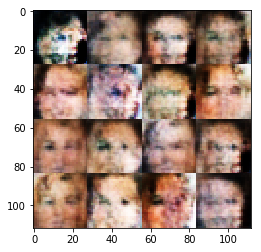

Epoch 1/1,  Batch 1620,  Discriminator Loss: 1.0246,  Generator Loss: 1.3836
Epoch 1/1,  Batch 1640,  Discriminator Loss: 1.1554,  Generator Loss: 0.8588
Epoch 1/1,  Batch 1660,  Discriminator Loss: 0.9864,  Generator Loss: 1.0539
Epoch 1/1,  Batch 1680,  Discriminator Loss: 1.0667,  Generator Loss: 1.4301
Epoch 1/1,  Batch 1700,  Discriminator Loss: 1.0987,  Generator Loss: 1.1355
Epoch 1/1,  Batch 1720,  Discriminator Loss: 1.0462,  Generator Loss: 0.9565
Epoch 1/1,  Batch 1740,  Discriminator Loss: 0.9951,  Generator Loss: 1.3006
Epoch 1/1,  Batch 1760,  Discriminator Loss: 0.8694,  Generator Loss: 1.3322
Epoch 1/1,  Batch 1780,  Discriminator Loss: 1.0741,  Generator Loss: 1.0447
Epoch 1/1,  Batch 1800,  Discriminator Loss: 0.9443,  Generator Loss: 1.1108


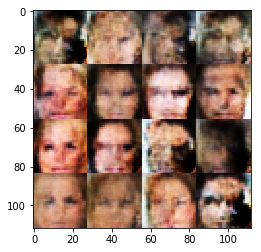

Epoch 1/1,  Batch 1820,  Discriminator Loss: 1.2677,  Generator Loss: 1.2841
Epoch 1/1,  Batch 1840,  Discriminator Loss: 1.0929,  Generator Loss: 0.8785
Epoch 1/1,  Batch 1860,  Discriminator Loss: 1.0836,  Generator Loss: 1.1694
Epoch 1/1,  Batch 1880,  Discriminator Loss: 1.0553,  Generator Loss: 0.9517
Epoch 1/1,  Batch 1900,  Discriminator Loss: 1.1178,  Generator Loss: 0.9333
Epoch 1/1,  Batch 1920,  Discriminator Loss: 1.1677,  Generator Loss: 0.8634
Epoch 1/1,  Batch 1940,  Discriminator Loss: 1.0780,  Generator Loss: 0.9050
Epoch 1/1,  Batch 1960,  Discriminator Loss: 0.8387,  Generator Loss: 1.8969
Epoch 1/1,  Batch 1980,  Discriminator Loss: 1.0025,  Generator Loss: 1.2565
Epoch 1/1,  Batch 2000,  Discriminator Loss: 1.0369,  Generator Loss: 1.1930


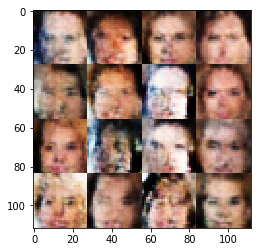

Epoch 1/1,  Batch 2020,  Discriminator Loss: 0.9293,  Generator Loss: 1.2898
Epoch 1/1,  Batch 2040,  Discriminator Loss: 1.0309,  Generator Loss: 0.9675
Epoch 1/1,  Batch 2060,  Discriminator Loss: 0.9154,  Generator Loss: 1.3568
Epoch 1/1,  Batch 2080,  Discriminator Loss: 0.9443,  Generator Loss: 1.3489
Epoch 1/1,  Batch 2100,  Discriminator Loss: 0.9258,  Generator Loss: 1.2096
Epoch 1/1,  Batch 2120,  Discriminator Loss: 1.1279,  Generator Loss: 0.9207
Epoch 1/1,  Batch 2140,  Discriminator Loss: 1.0408,  Generator Loss: 1.1528
Epoch 1/1,  Batch 2160,  Discriminator Loss: 1.0109,  Generator Loss: 1.3038
Epoch 1/1,  Batch 2180,  Discriminator Loss: 1.0921,  Generator Loss: 0.9433
Epoch 1/1,  Batch 2200,  Discriminator Loss: 1.0289,  Generator Loss: 1.1449


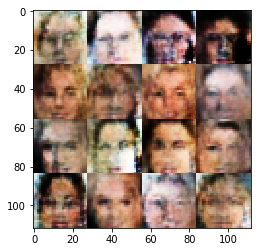

Epoch 1/1,  Batch 2220,  Discriminator Loss: 1.0840,  Generator Loss: 1.0626
Epoch 1/1,  Batch 2240,  Discriminator Loss: 1.0286,  Generator Loss: 1.4642
Epoch 1/1,  Batch 2260,  Discriminator Loss: 0.9679,  Generator Loss: 1.2125
Epoch 1/1,  Batch 2280,  Discriminator Loss: 1.0468,  Generator Loss: 1.0965
Epoch 1/1,  Batch 2300,  Discriminator Loss: 1.0935,  Generator Loss: 1.1911
Epoch 1/1,  Batch 2320,  Discriminator Loss: 0.9016,  Generator Loss: 1.6046
Epoch 1/1,  Batch 2340,  Discriminator Loss: 0.8610,  Generator Loss: 1.6218
Epoch 1/1,  Batch 2360,  Discriminator Loss: 1.0788,  Generator Loss: 1.1820
Epoch 1/1,  Batch 2380,  Discriminator Loss: 1.0435,  Generator Loss: 1.1493
Epoch 1/1,  Batch 2400,  Discriminator Loss: 1.1389,  Generator Loss: 1.0304


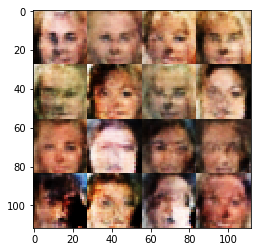

Epoch 1/1,  Batch 2420,  Discriminator Loss: 1.1066,  Generator Loss: 1.1431
Epoch 1/1,  Batch 2440,  Discriminator Loss: 1.0891,  Generator Loss: 1.0574
Epoch 1/1,  Batch 2460,  Discriminator Loss: 0.8748,  Generator Loss: 1.4992
Epoch 1/1,  Batch 2480,  Discriminator Loss: 0.9250,  Generator Loss: 1.6763
Epoch 1/1,  Batch 2500,  Discriminator Loss: 1.0419,  Generator Loss: 1.2626
Epoch 1/1,  Batch 2520,  Discriminator Loss: 1.1504,  Generator Loss: 0.8405
Epoch 1/1,  Batch 2540,  Discriminator Loss: 1.1333,  Generator Loss: 0.9729
Epoch 1/1,  Batch 2560,  Discriminator Loss: 1.0061,  Generator Loss: 1.0855
Epoch 1/1,  Batch 2580,  Discriminator Loss: 0.7394,  Generator Loss: 1.9370
Epoch 1/1,  Batch 2600,  Discriminator Loss: 0.8723,  Generator Loss: 1.3576


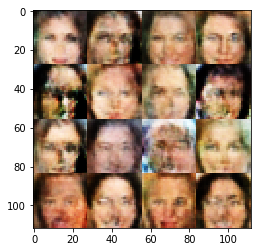

Epoch 1/1,  Batch 2620,  Discriminator Loss: 0.9949,  Generator Loss: 1.2002
Epoch 1/1,  Batch 2640,  Discriminator Loss: 1.0261,  Generator Loss: 1.0113
Epoch 1/1,  Batch 2660,  Discriminator Loss: 0.9334,  Generator Loss: 1.0624
Epoch 1/1,  Batch 2680,  Discriminator Loss: 1.0261,  Generator Loss: 1.1966
Epoch 1/1,  Batch 2700,  Discriminator Loss: 0.9817,  Generator Loss: 1.3447
Epoch 1/1,  Batch 2720,  Discriminator Loss: 1.1071,  Generator Loss: 1.0841
Epoch 1/1,  Batch 2740,  Discriminator Loss: 1.9151,  Generator Loss: 1.0870
Epoch 1/1,  Batch 2760,  Discriminator Loss: 0.9067,  Generator Loss: 1.3197
Epoch 1/1,  Batch 2780,  Discriminator Loss: 1.0003,  Generator Loss: 1.1309
Epoch 1/1,  Batch 2800,  Discriminator Loss: 1.0981,  Generator Loss: 0.9543


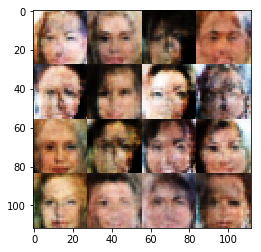

Epoch 1/1,  Batch 2820,  Discriminator Loss: 1.2077,  Generator Loss: 1.4088
Epoch 1/1,  Batch 2840,  Discriminator Loss: 1.1207,  Generator Loss: 1.1339
Epoch 1/1,  Batch 2860,  Discriminator Loss: 1.0419,  Generator Loss: 1.0554
Epoch 1/1,  Batch 2880,  Discriminator Loss: 1.1278,  Generator Loss: 0.9633
Epoch 1/1,  Batch 2900,  Discriminator Loss: 0.9406,  Generator Loss: 1.2317
Epoch 1/1,  Batch 2920,  Discriminator Loss: 1.0848,  Generator Loss: 1.1491
Epoch 1/1,  Batch 2940,  Discriminator Loss: 0.8680,  Generator Loss: 1.4713
Epoch 1/1,  Batch 2960,  Discriminator Loss: 1.1822,  Generator Loss: 0.7656
Epoch 1/1,  Batch 2980,  Discriminator Loss: 0.9805,  Generator Loss: 1.2823
Epoch 1/1,  Batch 3000,  Discriminator Loss: 1.1205,  Generator Loss: 1.0005


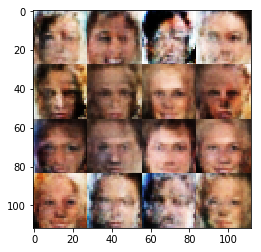

Epoch 1/1,  Batch 3020,  Discriminator Loss: 0.9987,  Generator Loss: 1.0807
Epoch 1/1,  Batch 3040,  Discriminator Loss: 0.9691,  Generator Loss: 1.1623
Epoch 1/1,  Batch 3060,  Discriminator Loss: 1.0072,  Generator Loss: 1.3239
Epoch 1/1,  Batch 3080,  Discriminator Loss: 0.9364,  Generator Loss: 1.1751
Epoch 1/1,  Batch 3100,  Discriminator Loss: 1.2544,  Generator Loss: 0.7155
Epoch 1/1,  Batch 3120,  Discriminator Loss: 1.1243,  Generator Loss: 1.0213
Epoch 1/1,  Batch 3140,  Discriminator Loss: 0.8641,  Generator Loss: 1.4114
Epoch 1/1,  Batch 3160,  Discriminator Loss: 1.0092,  Generator Loss: 1.0437
Epoch 1/1,  Batch 3180,  Discriminator Loss: 1.0495,  Generator Loss: 1.2357
Epoch 1/1,  Batch 3200,  Discriminator Loss: 1.0745,  Generator Loss: 1.1349


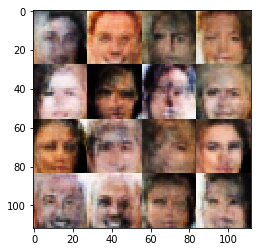

Epoch 1/1,  Batch 3220,  Discriminator Loss: 1.0842,  Generator Loss: 1.1808
Epoch 1/1,  Batch 3240,  Discriminator Loss: 0.9422,  Generator Loss: 1.3364
Epoch 1/1,  Batch 3260,  Discriminator Loss: 1.0467,  Generator Loss: 1.0269
Epoch 1/1,  Batch 3280,  Discriminator Loss: 1.0997,  Generator Loss: 1.0746
Epoch 1/1,  Batch 3300,  Discriminator Loss: 0.9609,  Generator Loss: 1.1196
Epoch 1/1,  Batch 3320,  Discriminator Loss: 0.9779,  Generator Loss: 1.2623
Epoch 1/1,  Batch 3340,  Discriminator Loss: 1.0660,  Generator Loss: 1.1763
Epoch 1/1,  Batch 3360,  Discriminator Loss: 0.8347,  Generator Loss: 1.6421
Epoch 1/1,  Batch 3380,  Discriminator Loss: 0.9590,  Generator Loss: 1.5950
Epoch 1/1,  Batch 3400,  Discriminator Loss: 1.0265,  Generator Loss: 1.1118


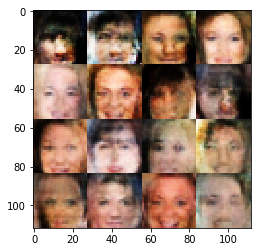

Epoch 1/1,  Batch 3420,  Discriminator Loss: 1.1350,  Generator Loss: 0.9989
Epoch 1/1,  Batch 3440,  Discriminator Loss: 1.2147,  Generator Loss: 0.9377
Epoch 1/1,  Batch 3460,  Discriminator Loss: 1.0674,  Generator Loss: 1.0734
Epoch 1/1,  Batch 3480,  Discriminator Loss: 1.1755,  Generator Loss: 0.8821
Epoch 1/1,  Batch 3500,  Discriminator Loss: 1.0458,  Generator Loss: 1.1804
Epoch 1/1,  Batch 3520,  Discriminator Loss: 1.1909,  Generator Loss: 0.8890
Epoch 1/1,  Batch 3540,  Discriminator Loss: 1.1601,  Generator Loss: 0.9131
Epoch 1/1,  Batch 3560,  Discriminator Loss: 0.9445,  Generator Loss: 1.3642
Epoch 1/1,  Batch 3580,  Discriminator Loss: 1.0495,  Generator Loss: 0.9160
Epoch 1/1,  Batch 3600,  Discriminator Loss: 0.9976,  Generator Loss: 1.1050


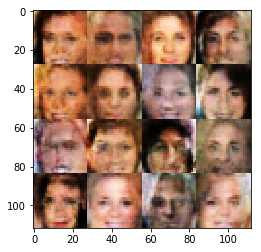

Epoch 1/1,  Batch 3620,  Discriminator Loss: 1.1833,  Generator Loss: 1.0382
Epoch 1/1,  Batch 3640,  Discriminator Loss: 1.0917,  Generator Loss: 0.9668
Epoch 1/1,  Batch 3660,  Discriminator Loss: 1.0751,  Generator Loss: 1.1283
Epoch 1/1,  Batch 3680,  Discriminator Loss: 0.9620,  Generator Loss: 1.0728
Epoch 1/1,  Batch 3700,  Discriminator Loss: 1.0676,  Generator Loss: 1.0799
Epoch 1/1,  Batch 3720,  Discriminator Loss: 1.0444,  Generator Loss: 1.0985
Epoch 1/1,  Batch 3740,  Discriminator Loss: 1.2138,  Generator Loss: 1.3225
Epoch 1/1,  Batch 3760,  Discriminator Loss: 1.0616,  Generator Loss: 1.0680
Epoch 1/1,  Batch 3780,  Discriminator Loss: 1.0788,  Generator Loss: 1.1389
Epoch 1/1,  Batch 3800,  Discriminator Loss: 1.1872,  Generator Loss: 0.9048


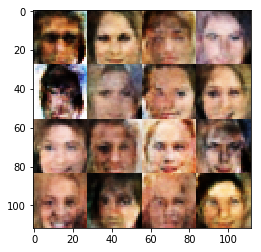

Epoch 1/1,  Batch 3820,  Discriminator Loss: 1.2083,  Generator Loss: 1.0270
Epoch 1/1,  Batch 3840,  Discriminator Loss: 1.0709,  Generator Loss: 1.0185
Epoch 1/1,  Batch 3860,  Discriminator Loss: 1.0036,  Generator Loss: 1.0305
Epoch 1/1,  Batch 3880,  Discriminator Loss: 1.0830,  Generator Loss: 0.9344
Epoch 1/1,  Batch 3900,  Discriminator Loss: 0.9367,  Generator Loss: 1.3091
Epoch 1/1,  Batch 3920,  Discriminator Loss: 1.0987,  Generator Loss: 1.1134
Epoch 1/1,  Batch 3940,  Discriminator Loss: 0.9045,  Generator Loss: 1.3494
Epoch 1/1,  Batch 3960,  Discriminator Loss: 0.8520,  Generator Loss: 1.7548
Epoch 1/1,  Batch 3980,  Discriminator Loss: 0.9894,  Generator Loss: 1.2755
Epoch 1/1,  Batch 4000,  Discriminator Loss: 1.1415,  Generator Loss: 1.0767


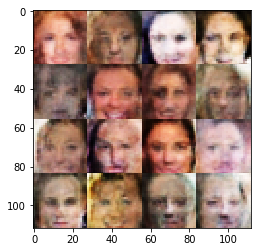

Epoch 1/1,  Batch 4020,  Discriminator Loss: 0.9651,  Generator Loss: 1.0384
Epoch 1/1,  Batch 4040,  Discriminator Loss: 1.0633,  Generator Loss: 1.2108
Epoch 1/1,  Batch 4060,  Discriminator Loss: 1.0312,  Generator Loss: 1.0816
Epoch 1/1,  Batch 4080,  Discriminator Loss: 1.1909,  Generator Loss: 0.9238
Epoch 1/1,  Batch 4100,  Discriminator Loss: 1.1109,  Generator Loss: 0.9362
Epoch 1/1,  Batch 4120,  Discriminator Loss: 0.9852,  Generator Loss: 1.0481
Epoch 1/1,  Batch 4140,  Discriminator Loss: 1.0484,  Generator Loss: 1.0308
Epoch 1/1,  Batch 4160,  Discriminator Loss: 0.7156,  Generator Loss: 2.4369
Epoch 1/1,  Batch 4180,  Discriminator Loss: 1.0161,  Generator Loss: 1.0330
Epoch 1/1,  Batch 4200,  Discriminator Loss: 1.0336,  Generator Loss: 1.3385


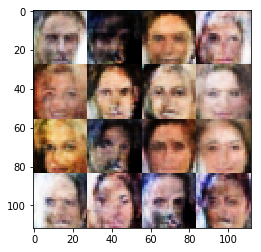

Epoch 1/1,  Batch 4220,  Discriminator Loss: 0.9141,  Generator Loss: 1.5136
Epoch 1/1,  Batch 4240,  Discriminator Loss: 1.0765,  Generator Loss: 1.0474
Epoch 1/1,  Batch 4260,  Discriminator Loss: 0.9371,  Generator Loss: 1.3180
Epoch 1/1,  Batch 4280,  Discriminator Loss: 0.9309,  Generator Loss: 1.2703
Epoch 1/1,  Batch 4300,  Discriminator Loss: 1.0388,  Generator Loss: 1.3048
Epoch 1/1,  Batch 4320,  Discriminator Loss: 1.0993,  Generator Loss: 0.9753
Epoch 1/1,  Batch 4340,  Discriminator Loss: 0.8404,  Generator Loss: 1.7072
Epoch 1/1,  Batch 4360,  Discriminator Loss: 0.8770,  Generator Loss: 1.5708
Epoch 1/1,  Batch 4380,  Discriminator Loss: 0.9513,  Generator Loss: 1.4992
Epoch 1/1,  Batch 4400,  Discriminator Loss: 0.9697,  Generator Loss: 1.2751


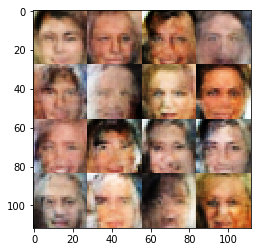

Epoch 1/1,  Batch 4420,  Discriminator Loss: 1.0854,  Generator Loss: 1.0236
Epoch 1/1,  Batch 4440,  Discriminator Loss: 1.1064,  Generator Loss: 0.8237
Epoch 1/1,  Batch 4460,  Discriminator Loss: 0.9501,  Generator Loss: 1.1314
Epoch 1/1,  Batch 4480,  Discriminator Loss: 0.9654,  Generator Loss: 1.0730
Epoch 1/1,  Batch 4500,  Discriminator Loss: 1.1248,  Generator Loss: 0.9084
Epoch 1/1,  Batch 4520,  Discriminator Loss: 1.1737,  Generator Loss: 0.9340
Epoch 1/1,  Batch 4540,  Discriminator Loss: 0.9080,  Generator Loss: 1.6768
Epoch 1/1,  Batch 4560,  Discriminator Loss: 1.1421,  Generator Loss: 0.8853
Epoch 1/1,  Batch 4580,  Discriminator Loss: 1.0246,  Generator Loss: 1.1517
Epoch 1/1,  Batch 4600,  Discriminator Loss: 1.0086,  Generator Loss: 1.1748


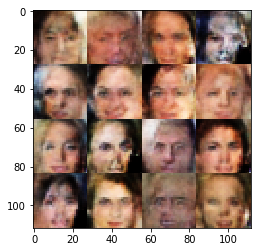

Epoch 1/1,  Batch 4620,  Discriminator Loss: 1.0295,  Generator Loss: 1.1539
Epoch 1/1,  Batch 4640,  Discriminator Loss: 0.9587,  Generator Loss: 1.6340
Epoch 1/1,  Batch 4660,  Discriminator Loss: 1.2609,  Generator Loss: 1.1744
Epoch 1/1,  Batch 4680,  Discriminator Loss: 1.1463,  Generator Loss: 1.3509
Epoch 1/1,  Batch 4700,  Discriminator Loss: 0.9913,  Generator Loss: 1.0352
Epoch 1/1,  Batch 4720,  Discriminator Loss: 0.9887,  Generator Loss: 1.1943
Epoch 1/1,  Batch 4740,  Discriminator Loss: 1.0324,  Generator Loss: 1.1459
Epoch 1/1,  Batch 4760,  Discriminator Loss: 1.0976,  Generator Loss: 1.1136
Epoch 1/1,  Batch 4780,  Discriminator Loss: 0.9896,  Generator Loss: 1.1636
Epoch 1/1,  Batch 4800,  Discriminator Loss: 0.9035,  Generator Loss: 1.2760


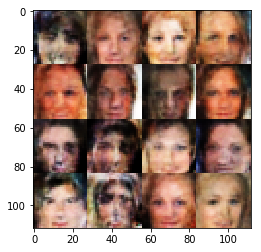

Epoch 1/1,  Batch 4820,  Discriminator Loss: 1.4656,  Generator Loss: 1.1373
Epoch 1/1,  Batch 4840,  Discriminator Loss: 1.1133,  Generator Loss: 0.9986
Epoch 1/1,  Batch 4860,  Discriminator Loss: 0.9735,  Generator Loss: 1.2900
Epoch 1/1,  Batch 4880,  Discriminator Loss: 0.9619,  Generator Loss: 1.1746
Epoch 1/1,  Batch 4900,  Discriminator Loss: 1.0934,  Generator Loss: 0.9379
Epoch 1/1,  Batch 4920,  Discriminator Loss: 0.9605,  Generator Loss: 1.2801
Epoch 1/1,  Batch 4940,  Discriminator Loss: 0.8873,  Generator Loss: 1.6215
Epoch 1/1,  Batch 4960,  Discriminator Loss: 1.0386,  Generator Loss: 1.1428
Epoch 1/1,  Batch 4980,  Discriminator Loss: 0.9710,  Generator Loss: 1.3249
Epoch 1/1,  Batch 5000,  Discriminator Loss: 1.1042,  Generator Loss: 1.0450


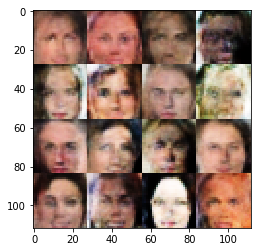

Epoch 1/1,  Batch 5020,  Discriminator Loss: 1.0727,  Generator Loss: 1.4464
Epoch 1/1,  Batch 5040,  Discriminator Loss: 0.9709,  Generator Loss: 1.0641
Epoch 1/1,  Batch 5060,  Discriminator Loss: 1.1578,  Generator Loss: 0.8827
Epoch 1/1,  Batch 5080,  Discriminator Loss: 1.1038,  Generator Loss: 0.9044
Epoch 1/1,  Batch 5100,  Discriminator Loss: 0.8029,  Generator Loss: 1.8898
Epoch 1/1,  Batch 5120,  Discriminator Loss: 1.0643,  Generator Loss: 1.2876
Epoch 1/1,  Batch 5140,  Discriminator Loss: 1.1243,  Generator Loss: 1.0653
Epoch 1/1,  Batch 5160,  Discriminator Loss: 0.9992,  Generator Loss: 1.1774
Epoch 1/1,  Batch 5180,  Discriminator Loss: 0.9057,  Generator Loss: 1.2041
Epoch 1/1,  Batch 5200,  Discriminator Loss: 0.9779,  Generator Loss: 1.1945


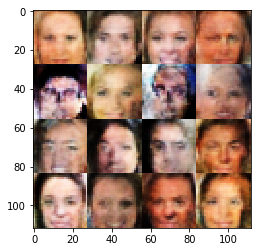

Epoch 1/1,  Batch 5220,  Discriminator Loss: 0.8513,  Generator Loss: 2.0891
Epoch 1/1,  Batch 5240,  Discriminator Loss: 1.0352,  Generator Loss: 1.1601
Epoch 1/1,  Batch 5260,  Discriminator Loss: 1.0267,  Generator Loss: 1.1303
Epoch 1/1,  Batch 5280,  Discriminator Loss: 1.1719,  Generator Loss: 0.8218
Epoch 1/1,  Batch 5300,  Discriminator Loss: 0.9228,  Generator Loss: 1.7234
Epoch 1/1,  Batch 5320,  Discriminator Loss: 1.1166,  Generator Loss: 1.2849
Epoch 1/1,  Batch 5340,  Discriminator Loss: 0.9005,  Generator Loss: 1.2771
Epoch 1/1,  Batch 5360,  Discriminator Loss: 0.9869,  Generator Loss: 1.2552
Epoch 1/1,  Batch 5380,  Discriminator Loss: 1.0347,  Generator Loss: 1.1388
Epoch 1/1,  Batch 5400,  Discriminator Loss: 0.9868,  Generator Loss: 1.2401


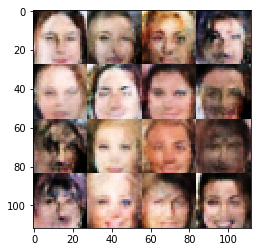

Epoch 1/1,  Batch 5420,  Discriminator Loss: 1.0296,  Generator Loss: 1.1849
Epoch 1/1,  Batch 5440,  Discriminator Loss: 0.9286,  Generator Loss: 1.3368
Epoch 1/1,  Batch 5460,  Discriminator Loss: 0.9721,  Generator Loss: 1.2453
Epoch 1/1,  Batch 5480,  Discriminator Loss: 1.0401,  Generator Loss: 1.8759
Epoch 1/1,  Batch 5500,  Discriminator Loss: 0.9690,  Generator Loss: 1.1871
Epoch 1/1,  Batch 5520,  Discriminator Loss: 0.8948,  Generator Loss: 1.6158
Epoch 1/1,  Batch 5540,  Discriminator Loss: 1.0414,  Generator Loss: 1.2183
Epoch 1/1,  Batch 5560,  Discriminator Loss: 1.0832,  Generator Loss: 1.1554
Epoch 1/1,  Batch 5580,  Discriminator Loss: 1.0178,  Generator Loss: 1.1924
Epoch 1/1,  Batch 5600,  Discriminator Loss: 1.0587,  Generator Loss: 1.1707


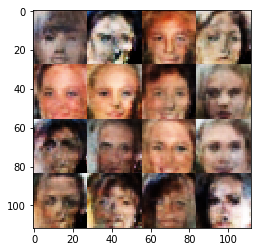

Epoch 1/1,  Batch 5620,  Discriminator Loss: 0.8872,  Generator Loss: 1.4036
Epoch 1/1,  Batch 5640,  Discriminator Loss: 0.9306,  Generator Loss: 1.2400
Epoch 1/1,  Batch 5660,  Discriminator Loss: 1.1159,  Generator Loss: 0.9324
Epoch 1/1,  Batch 5680,  Discriminator Loss: 0.9981,  Generator Loss: 1.1260
Epoch 1/1,  Batch 5700,  Discriminator Loss: 1.1059,  Generator Loss: 1.1110
Epoch 1/1,  Batch 5720,  Discriminator Loss: 1.1343,  Generator Loss: 1.0368
Epoch 1/1,  Batch 5740,  Discriminator Loss: 1.0294,  Generator Loss: 0.9914
Epoch 1/1,  Batch 5760,  Discriminator Loss: 1.0637,  Generator Loss: 1.1077
Epoch 1/1,  Batch 5780,  Discriminator Loss: 1.0689,  Generator Loss: 1.0676
Epoch 1/1,  Batch 5800,  Discriminator Loss: 0.9816,  Generator Loss: 1.1769


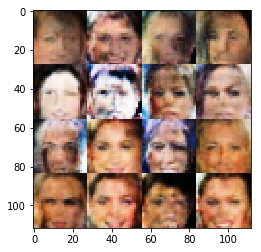

Epoch 1/1,  Batch 5820,  Discriminator Loss: 0.9148,  Generator Loss: 1.3594
Epoch 1/1,  Batch 5840,  Discriminator Loss: 0.9587,  Generator Loss: 1.2360
Epoch 1/1,  Batch 5860,  Discriminator Loss: 1.0165,  Generator Loss: 1.1075
Epoch 1/1,  Batch 5880,  Discriminator Loss: 1.0602,  Generator Loss: 1.1143
Epoch 1/1,  Batch 5900,  Discriminator Loss: 1.0845,  Generator Loss: 0.9255
Epoch 1/1,  Batch 5920,  Discriminator Loss: 1.0832,  Generator Loss: 0.8658
Epoch 1/1,  Batch 5940,  Discriminator Loss: 1.0278,  Generator Loss: 0.9956
Epoch 1/1,  Batch 5960,  Discriminator Loss: 1.0636,  Generator Loss: 0.9719
Epoch 1/1,  Batch 5980,  Discriminator Loss: 1.1107,  Generator Loss: 0.9549
Epoch 1/1,  Batch 6000,  Discriminator Loss: 1.0317,  Generator Loss: 1.3874


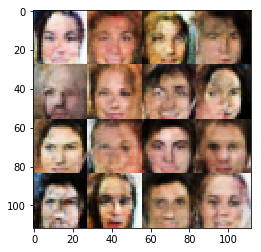

Epoch 1/1,  Batch 6020,  Discriminator Loss: 1.1450,  Generator Loss: 0.8784
Epoch 1/1,  Batch 6040,  Discriminator Loss: 0.9498,  Generator Loss: 1.1916
Epoch 1/1,  Batch 6060,  Discriminator Loss: 1.0845,  Generator Loss: 1.1463
Epoch 1/1,  Batch 6080,  Discriminator Loss: 1.0282,  Generator Loss: 1.2304
Epoch 1/1,  Batch 6100,  Discriminator Loss: 0.9173,  Generator Loss: 1.5313
Epoch 1/1,  Batch 6120,  Discriminator Loss: 1.2078,  Generator Loss: 1.1048
Epoch 1/1,  Batch 6140,  Discriminator Loss: 1.1929,  Generator Loss: 0.9119
Epoch 1/1,  Batch 6160,  Discriminator Loss: 1.1232,  Generator Loss: 1.1205
Epoch 1/1,  Batch 6180,  Discriminator Loss: 0.9537,  Generator Loss: 1.3465
Epoch 1/1,  Batch 6200,  Discriminator Loss: 1.0033,  Generator Loss: 1.1059


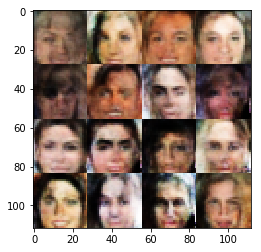

Epoch 1/1,  Batch 6220,  Discriminator Loss: 1.3091,  Generator Loss: 0.7384
Epoch 1/1,  Batch 6240,  Discriminator Loss: 1.0380,  Generator Loss: 1.0017
Epoch 1/1,  Batch 6260,  Discriminator Loss: 0.9203,  Generator Loss: 1.3460
Epoch 1/1,  Batch 6280,  Discriminator Loss: 1.0020,  Generator Loss: 1.0538
Epoch 1/1,  Batch 6300,  Discriminator Loss: 1.0341,  Generator Loss: 1.1493
Epoch 1/1,  Batch 6320,  Discriminator Loss: 0.9948,  Generator Loss: 1.1836


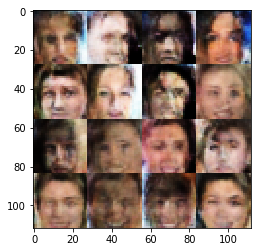

GAN is completed.


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.